⏳ Đang tải dữ liệu...
Tổng số mẫu: 12169
Tỷ lệ lớp ban đầu: {0: 11668, 1: 501} (0: Inside, 1: Outside)

Train size: 9735 samples
Test size: 2434 samples

⏳ Đang chạy GridSearchCV (5-Fold CV)... quá trình này có thể mất vài phút.
Fitting 5 folds for each of 27 candidates, totalling 135 fits

✅ Best Params: {'rf__max_depth': 12, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 300}
✅ Best CV F1-Macro Score: 0.9558

--- KẾT QUẢ TRÊN TẬP TEST ---
Confusion Matrix:
[[2319   15]
 [   1   99]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9936    0.9966      2334
           1     0.8684    0.9900    0.9252       100

    accuracy                         0.9934      2434
   macro avg     0.9340    0.9918    0.9609      2434
weighted avg     0.9942    0.9934    0.9936      2434

ROC-AUC Score: 0.9994


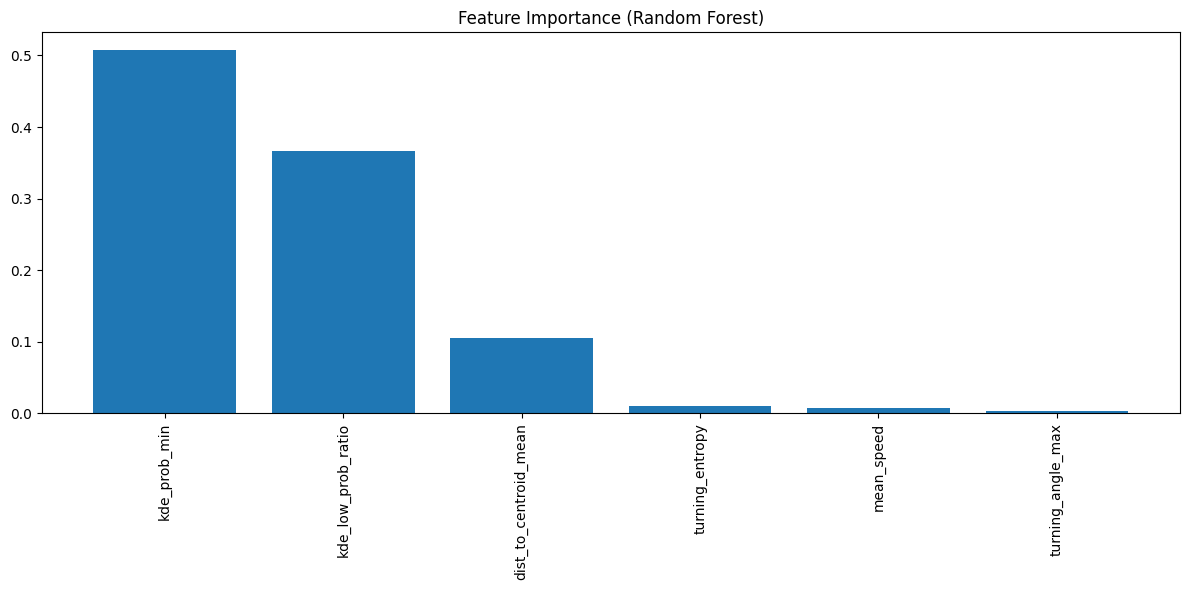

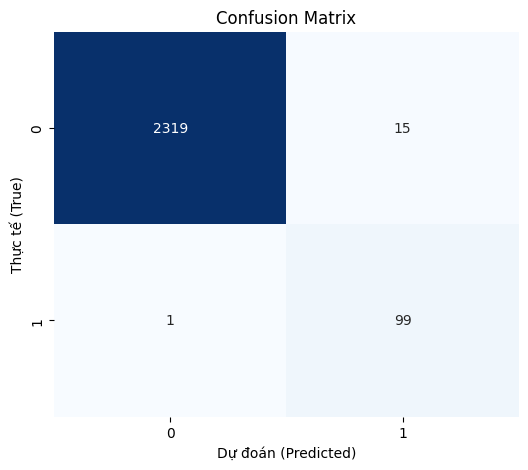


TÌM THRESHOLD TỐI ƯU...
✅ Threshold tốt nhất: 0.69
✅ F1-Score cao nhất đạt được: 0.9469

--- SO SÁNH HIỆU QUẢ ---
F1-Score (Mặc định 0.5): 0.9252
F1-Score (Tối ưu 0.69): 0.9469

--- BÁO CÁO CHI TIẾT (SAU KHI TỐI ƯU) ---
              precision    recall  f1-score   support

           0     0.9991    0.9961    0.9976      2334
           1     0.9159    0.9800    0.9469       100

    accuracy                         0.9955      2434
   macro avg     0.9575    0.9881    0.9722      2434
weighted avg     0.9957    0.9955    0.9956      2434

Confusion Matrix (Tối ưu):
[[2325    9]
 [   2   98]]


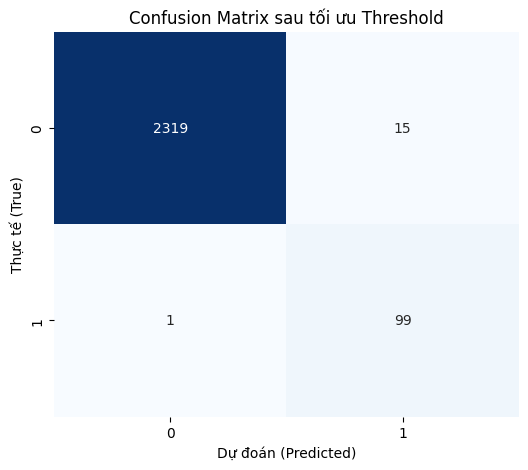

Xuat file model
Xuat file model thanh cong
load lai model
Threshold được lưu trong file: 0.6900000000000001
F1-Score sau khi load lại: 0.9469
Model load lai y het nhu train
Kết quả không khớp.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from importlib import reload


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline as SklearnPipeline

# Quan trọng: Dùng Pipeline của imblearn để tránh Data Leakage khi resample trong CV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 1. Đọc và chuẩn bị dữ liệu
print("⏳ Đang tải dữ liệu...")
df = pd.read_csv('elephant_6features_cleaned.csv')

# Tách Feature (X) và Target (y)
X = df.drop(columns=['is_outside'])
y = df['is_outside']

print(f"Tổng số mẫu: {len(X)}")
print(f"Tỷ lệ lớp ban đầu: {y.value_counts().to_dict()} (0: Inside, 1: Outside)")
# 2. Split Train/Test (80/20, Stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"\nTrain size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

# 3. Thiết lập Pipeline: SMOTE -> UnderSampler -> Random Forest
# sampling_strategy=0.5: Số lượng mẫu thiểu số (1) sẽ bằng 50% số lượng mẫu đa số (0) sau SMOTE
# sampling_strategy=0.8: Số lượng mẫu đa số (0) sẽ bị giảm xuống sao cho mẫu thiểu số bằng 80% mẫu đa số
pipeline = ImbPipeline([
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=0.8, random_state=42)),
    ('rf', RandomForestClassifier(
        criterion='gini', 
        class_weight='balanced', 
        oob_score=True, 
        random_state=42, 
        n_jobs=-1
    ))
])

# 4. Thiết lập Grid Search Params
# Lưu ý: Dùng prefix 'rf__' để chỉ định tham số cho step 'rf' trong pipeline
param_grid = {
    'rf__n_estimators': [200, 300, 400],
    'rf__max_depth': [8, 10, 12],
    'rf__min_samples_leaf': [1, 2, 5]
}

# 5. Chạy GridSearchCV
print("\n⏳ Đang chạy GridSearchCV (5-Fold CV)... quá trình này có thể mất vài phút.")
# scoring='f1_macro' để cân bằng giữa độ chính xác của lớp 0 và lớp 1
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# 6. Kết quả tốt nhất
best_model = grid_search.best_estimator_
print("\n" + "="*40)
print(f"✅ Best Params: {grid_search.best_params_}")
print(f"✅ Best CV F1-Macro Score: {grid_search.best_score_:.4f}")
print("="*40)

# 7. Đánh giá trên tập Test
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n--- KẾT QUẢ TRÊN TẬP TEST ---")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 8. Trực quan hóa

# Biểu đồ Feature Importance (Lấy từ step 'rf' trong pipeline tốt nhất)
rf_best = best_model.named_steps['rf']
importances = rf_best.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

# Biểu đồ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Thực tế (True)')
plt.xlabel('Dự đoán (Predicted)')
plt.show()

#giai thuat tim threshold toi uu cho model de dat f1-score cao nhat
print("\n" + "="*40)
print("TÌM THRESHOLD TỐI ƯU...")

thresholds = np.arange(0.01, 1.0, 0.01) # Quét từ 0.01 đến 0.99
f1_scores = []

for t in thresholds:
    # Nếu xác suất >= t thì gán là 1, ngược lại là 0
    y_pred_temp = (y_prob >= t).astype(int)
    # Tính F1 cho lớp 1 (lớp quan trọng)
    score = f1_score(y_test, y_pred_temp) 
    f1_scores.append(score)

# Lấy ngưỡng có F1 cao nhất
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"✅ Threshold tốt nhất: {best_threshold:.2f}")
print(f"✅ F1-Score cao nhất đạt được: {best_f1:.4f}")

# Áp dụng ngưỡng mới để dự đoán lại
y_pred_optimized = (y_prob >= best_threshold).astype(int)

print("\n--- SO SÁNH HIỆU QUẢ ---")
print(f"F1-Score (Mặc định 0.5): {f1_score(y_test, y_pred):.4f}")
print(f"F1-Score (Tối ưu {best_threshold:.2f}): {best_f1:.4f}")

print("\n--- BÁO CÁO CHI TIẾT (SAU KHI TỐI ƯU) ---")
print(classification_report(y_test, y_pred_optimized, digits=4))

print("Confusion Matrix (Tối ưu):")
cm_opt = confusion_matrix(y_test, y_pred_optimized)
print(cm_opt)
print("="*40)

# Biểu đồ Confusion Matrix sau khi tối ưu
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix sau tối ưu Threshold')
plt.ylabel('Thực tế (True)')
plt.xlabel('Dự đoán (Predicted)')
plt.show()

#xuat file model 
reload(joblib)
#tao class de khi load model o file py khac thi phai copy class vao file do truoc khi load, neu ko se bi loi
class ElephantAnomalyDetector:
    def __init__ (self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict(self, X):
        self.model.predict_proba(X)[:, 1]
        return (y_prob >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

final_model_package = ElephantAnomalyDetector(
    model = best_model,
    threshold = best_threshold
) 
print('Xuat file model')
filename = 'model.pkl'
joblib.dump(final_model_package, filename)
print('Xuat file model thanh cong')
#load lai model de kiem thu xem co dung voi threshold toi uu voi f1-score toi uu ko
print('load lai model')
loaded_model = joblib.load(filename)

#du doan lai
y_pred_new = loaded_model.predict(X_test)

from sklearn.metrics import f1_score
f1_new = f1_score(y_test, y_pred_new)

print(f"Threshold được lưu trong file: {loaded_model.threshold}")
print(f"F1-Score sau khi load lại: {f1_new:.4f}")

if f1_new == best_f1:
    print("Model load lai y het nhu train")
    print("Kết quả không khớp.")
